In [1]:
from ultralytics import YOLO
from torch.utils.data import Dataset ,DataLoader
import os
import numpy as np
import tqdm
import cv2

# Load the model
model = YOLO('./12_model.pt')  # load a pretrained model
print(type(model.names),len(model.names))

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'dict'> 12


In [11]:
image_path = './test/images'
label_path = './test/labels'

image_filepaths = sorted([os.path.join(image_path, f) for f in os.listdir(image_path)])
label_filepaths = sorted([os.path.join(label_path, f) for f in os.listdir(label_path)])

class TestDataset(Dataset):    
    def __init__(self, image_list, label_list):    
        self.file_list = image_list
        self.label_list = label_list
        self.img_size = 640
        
    def __len__(self):
        return len(self.file_list)

    def xywh2xyxy(self,x):
        y = np.copy(x)
        y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
        y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
        y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
        y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
        return y
    
    def __getitem__(self, idx):        
        img_path = self.file_list[idx]
        label_path = self.label_list[idx]
        
        data_list = []
        with open(label_path, 'r') as file:
            for line in file:
                line_data = line.strip().split(' ')
                data_list.append([float(num) for num in line_data])

        # 리스트를 NumPy 배열로 변환
        numpy_array = np.array(data_list)
        numpy_array[:,1:] = self.xywh2xyxy(numpy_array[:,1:]) * self.img_size
        return img_path, numpy_array
    
test_dataset = TestDataset(image_filepaths,label_filepaths)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)     #객체 수가 달라서 batch_size는 1로 진행

In [12]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [13]:
img_vec_dict = {}
for key in range(12):
    img_vec_dict[key] = np.array([])
iou_thres = 0.7

for img_path, label in tqdm.tqdm(test_dataloader):
    results = model(img_path[0])
    box , img_vec = results[0][0].boxes.xyxy.cpu().numpy() , results[1][0].cpu().numpy()        # (객체수 , 4) / (target_num,128)
    label = label.squeeze(0).cpu().numpy()                                                                 # (실제 객체수 , 5)
    
    #print(box.shape,label.shape)
    if label.shape[0] > box.shape[0]:
        check_list = [True for _ in range(label.shape[0])]
        for ii , box_xyxy in enumerate(box):
            iou_list = []
            for i ,target_xyxy in enumerate(label):
                if check_list[i]:
                    iou_list.append(IoU(box_xyxy,target_xyxy[1:]))
                else: 
                    iou_list.append(0.0)
            iou_list = np.array(iou_list)
            #print(iou_list.shape,iou_list)
            if np.max(iou_list) < iou_thres:
                continue
            max_idx = np.argmax(iou_list)
            check_list[max_idx] = False

            
            label_idx = int(label[max_idx,0])
            if img_vec_dict[label_idx].shape[0]:
                img_vec_dict[label_idx] = np.vstack((img_vec_dict[label_idx], img_vec[ii]))
            else:
                img_vec_dict[label_idx] = img_vec[ii]
    
    else:
        check_list = [True for _ in range(box.shape[0])]
        for ii , target_xyxy in enumerate(label):
            iou_list = []
            for i ,box_xyxy in enumerate(box):
                if check_list[i]:
                    iou_list.append(IoU(box_xyxy,target_xyxy[1:]))
                else: 
                    iou_list.append(0.0)
            iou_list = np.array(iou_list)
            #print(iou_list.shape,iou_list)
            if np.max(iou_list) < iou_thres:
                continue
            max_idx = np.argmax(iou_list)
            check_list[max_idx] = False
            label_idx = int(target_xyxy[0])
            if img_vec_dict[label_idx].shape[0]:
                img_vec_dict[label_idx] = np.vstack((img_vec_dict[label_idx], img_vec[max_idx]))
            else:
                img_vec_dict[label_idx] = img_vec[max_idx]


100%|██████████| 3282/3282 [15:27<00:00,  3.54it/s]


In [15]:
for i ,(k,v) in enumerate(img_vec_dict.items()):
    print(v.shape)

y = np.concatenate([np.full((v.shape[0],1), i) for  i,v in enumerate(img_vec_dict.values())], axis=0)
x = np.concatenate([v for v in img_vec_dict.values()], axis=0)
y.shape , x.shape

(490, 128)
(495, 128)
(497, 128)
(496, 128)
(499, 128)
(499, 128)
(480, 128)
(477, 128)
(495, 128)
(495, 128)
(497, 128)
(477, 128)


((5897, 1), (5897, 128))

In [16]:
from sklearn.manifold import TSNE

train_x = TSNE(n_components=2,verbose=2).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5897 samples in 0.001s...
[t-SNE] Computed neighbors for 5897 samples in 0.515s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5897
[t-SNE] Computed conditional probabilities for sample 2000 / 5897
[t-SNE] Computed conditional probabilities for sample 3000 / 5897
[t-SNE] Computed conditional probabilities for sample 4000 / 5897
[t-SNE] Computed conditional probabilities for sample 5000 / 5897
[t-SNE] Computed conditional probabilities for sample 5897 / 5897
[t-SNE] Mean sigma: 1.957057
[t-SNE] Computed conditional probabilities in 0.150s
[t-SNE] Iteration 50: error = 76.0347137, gradient norm = 0.0389320 (50 iterations in 0.943s)
[t-SNE] Iteration 100: error = 66.7175140, gradient norm = 0.0144011 (50 iterations in 0.866s)
[t-SNE] Iteration 150: error = 64.0608902, gradient norm = 0.0090129 (50 iterations in 0.786s)
[t-SNE] Iteration 200: error = 62.7262077, gradient norm = 0.0064892 (50 iterations in 0.786s)
[t

In [17]:
train_x.shape

(5897, 2)

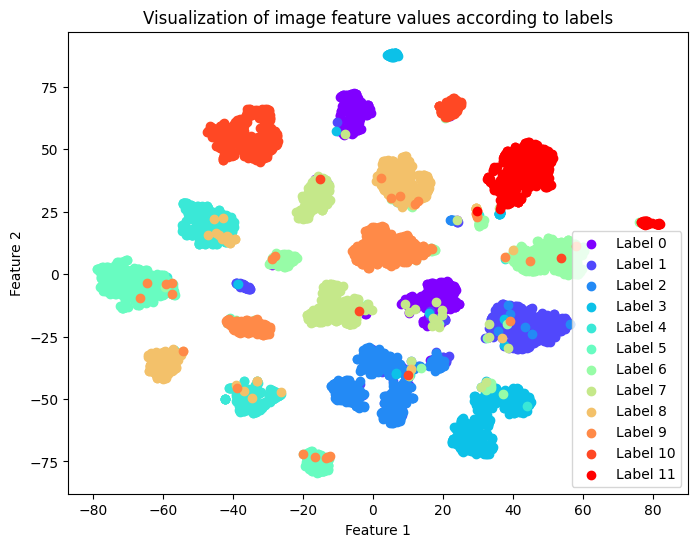

In [18]:
import matplotlib.pyplot as plt

# y의 라벨 값에 따라 색상 설정
cmap = plt.get_cmap('rainbow', 12)  # 12개의 색상을 rainbow colormap으로 설정

# 시각화
plt.figure(figsize=(8, 6))
for label in range(12):
    mask = (y == label).flatten()
    plt.scatter(train_x[mask, 0], train_x[mask, 1], color=cmap(label), label=f'Label {label}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of image feature values according to labels')
plt.legend()
plt.show()

In [2]:
## 테스트용
model = YOLO('./12_model.pt')  # load a pretrained model
print(type(model.names),len(model.names))

image = cv2.imread('test_orignal.png')
results = model(image)
boxes = results[0][0].boxes
for box in boxes:
    cls = box.cls.tolist()[0]
    conf = box.conf.tolist()[0]
    box = box.xyxy
    box = box.tolist()[0]
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    caption = 'class(' + str(int(cls)) + ') : ' + str(int(conf*100)) + '%'
    print(caption)
    cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 10)
cv2.imwrite("test_test.jpg", image)

<class 'dict'> 12


class(4) : 86%


True